# Implementació de la xarxa U-Net per a la segmentació de ferides


Aquest quadern serveix com a exemple per a iniciar-se a les xarxes neuronals. El que veurem serà l'estructura principal d'un quader de Jupyter, com definir un model de xarxa neuronal i fer-ne l'entrenament. Primer de tot, és una bona pràctica reservar la primera cel·la de codi per a fer tots els imports necessaris. Després, ja escriurem el codi.

In [1]:
import cv2
import glob
import numpy 
import os
import skimage

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from matplotlib import pyplot as plt
from numpy.random import seed
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend 
from tensorflow.keras.optimizers import *
from typing import Tuple, List

os.environ["CUDA_VISIBLE_DEVICES"]="-1"
seed(1)

2024-07-06 02:19:39.465734: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


## Lectura del *Redscar Dataset* i implementació del generador

Les imatges que s'empraran per a fer l'entrenament les anirem carregant a mesura que la xarxa les demani, per evitar carregar tot el dataset en memòria. Primer de tot, establirem la ruta del dataset.

In [2]:
REDSCAR_DATASET = "/home/marc/UIB_EXPERIMENTS/REDSCAR"
REDSCAR_DATASET_TRAIN = os.path.join(REDSCAR_DATASET, "SUBSETS", "MACHINE_LEARNING_DATASET", "train")
REDSCAR_DATASET_TEST = os.path.join(REDSCAR_DATASET, "SUBSETS", "MACHINE_LEARNING_DATASET", "test")

In [3]:
def neural_network_generator(img_path: str, gt_path: str, size: Tuple[int, int], batch_size: int):
    images = sorted(glob.glob(img_path))
    masks = sorted(glob.glob(gt_path))
    
    assert len(images) == len(masks), "The number of images and masks to be used must match."
    
    batch_img = []
    batch_mask = []
    idx = 1
    
    while(True):
        path_img = images[idx % len(images)]
        path_mask = masks[idx % len(images)]
    
        img = cv2.imread(path_img, 1)
        mask = cv2.imread(path_mask, 0)
        
        img = skimage.transform.resize(img, (size[0], size[1], 3))
        mask = cv2.resize(mask, size)
        
        mask = mask/255
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
            
        batch_img.append(img)
        batch_mask.append(mask)
        
        if (idx%(batch_size) == 0) and idx != 0:            
            batch_img = numpy.array(batch_img)
            batch_mask = numpy.array(batch_mask)
            
            yield batch_img, batch_mask
            
            batch_img = []
            batch_mask = []
        idx += 1
        
def validation_generator(img_path: str, gt_path: str, size: Tuple[int, int]):
    images_names = sorted(glob.glob(img_path))
    masks_names = sorted(glob.glob(gt_path))
    
    images = []
    masks = []
    
    for image_idx in range(len(images_names)):
        path_img = images_names[image_idx]
        path_mask = masks_names[image_idx]
    
        img = cv2.imread(path_img, 1)
        mask = cv2.imread(path_mask, 0)
        
        img = skimage.transform.resize(img, (size[0], size[1], 3))
        mask = cv2.resize(mask, size)
        
        mask = mask/255
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
        
        images.append(img)
        masks.append(mask)
    
    return (numpy.array(images), numpy.array(masks))

In [ ]:
IMAGES_TEST, GT_TEST = validation_generator(img_path=REDSCAR_DATASET_TEST+'/IMAGES/*.png', 
                       gt_path=REDSCAR_DATASET_TEST+'/GT_WOUND_MASK/*.png', 
                       size=(256, 256))

In [ ]:
BATCH_SIZE = 5
for image_batch, mask_batch in neural_network_generator(img_path=REDSCAR_DATASET_TRAIN+'/IMAGES/*.png', 
                                                        gt_path=REDSCAR_DATASET_TRAIN+'/GT_WOUND_MASK/*.png', 
                                                        size=(256, 256), 
                                                        batch_size=BATCH_SIZE):
    print(image_batch.shape, mask_batch.shape)
    for i in range(0, BATCH_SIZE):
        plt.imshow(image_batch[i,:,:,:])
        plt.show()
        plt.imshow(mask_batch[i,:,:])
        plt.show()
    break

## Implementació de la UNet

L'arquitectura UNet es va proposar per primera vegada a *U-Net: Convolutional Networks for Biomedical Image Segmentation*, per Ronneberger et al. És una xarxa del tipus codificador-decodificador, i la seva arquitectura es pot veure a la següent imatge.

![alternative text](unet_architecture.jpg)


El que farem serà implementar una funció per als blocs de codificació (els de l'esquerra), i una funció per als blocs de decodificació (els de la dreta).

In [6]:
def encoder_block(inputs, num_filters): 
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs) 
      
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(x) 
  
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Max Pooling with 2x2 filter 
    pooling = tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2)(x) 
      
    return x, pooling


def decoder_block(inputs, skip_features, num_filters): 
    
    # Upsampling with 2x2 filter
    up = tf.keras.layers.UpSampling2D(size = (2,2))(inputs)
    x = tf.keras.layers.Convolution2D(num_filters, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up)
    
    # Feature concatenation
    x = tf.keras.layers.concatenate([skip_features, x], axis = 3)
    
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Convolution2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Convolution2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    return x

In [7]:
def build_unet(input_shape=Tuple[int,int,int]):
    inputs = tf.keras.layers.Input(input_shape) 
      
    # Contracting path 
    c1, p1 = encoder_block(inputs, 64) 
    c2, p2 = encoder_block(p1, 128) 
    c3, p3 = encoder_block(p2, 256) 
    c4, p4 = encoder_block(p3, 512) 
      
    # Bottleneck 
    b1 = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(p4) 
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(b1) 
    b1 = tf.keras.layers.BatchNormalization()(b1)
    
    # Expansive path 
    e1 = decoder_block(b1, c4, 512) 
    e2 = decoder_block(e1, c3, 256) 
    e3 = decoder_block(e2, c2, 128) 
    e4 = decoder_block(e3, c1, 64) 
      
    # Output 
    final_layer = tf.keras.layers.Convolution2D(filters=2, kernel_size=3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(e4)
    final_layer = tf.keras.layers.BatchNormalization()(final_layer)
    outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding = 'same', kernel_initializer='he_normal')(final_layer) 
      
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs, name = 'U-Net') 
    return model

In [9]:
unet = build_unet(input_shape=(256, 256, 3)) 
unet.summary()

2023-12-21 12:24:56.874322: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-12-21 12:24:56.913036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2023-12-21 12:24:56.913097: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-12-21 12:24:56.915839: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-12-21 12:24:56.918201: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2023-12-21 12:24:56.918667: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

Model: "U-Net2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
_____________________________________________________________________________________________

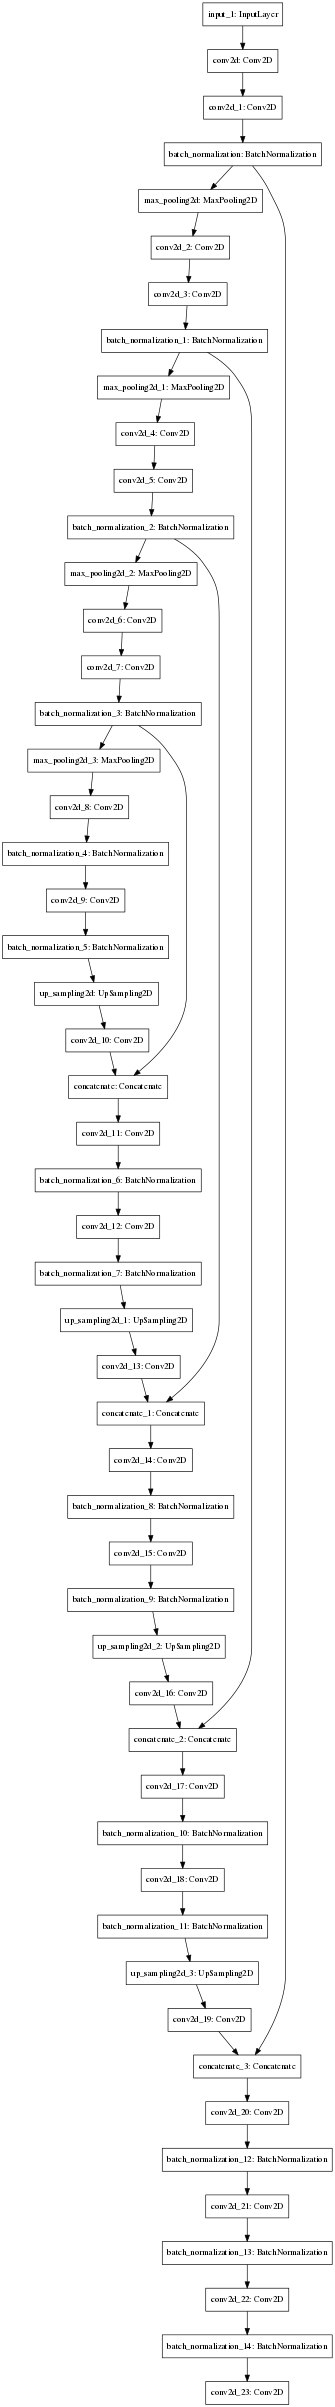

In [10]:
tf.keras.utils.plot_model(
    unet,
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=46,
)

## Entrenament de la UNet2

Ja ho tenim quasi a punt per a fer l'entrenament. Només ens queda definir la funció de pèrdua. Emprarem el coeficient de dice atès que és una mètrica emprada usualment en aquests casos.

In [2]:
def dice(y_true, y_pred):
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (2.* intersection+1) / (backend.sum(y_true_f) + backend.sum(y_pred_f)+1 )

def dice_loss(y_true, y_pred):
    return 1-dice(y_true, y_pred)

In [12]:
unet.compile(optimizer=Adam(learning_rate = 3e-4), loss=dice_loss, metrics = [dice])

In [13]:
BATCH_SIZE = 5
TOTAL_IMAGES = 275
STEPS_PER_EPOCH = TOTAL_IMAGES // BATCH_SIZE 
EPOCHS = 35

reduceLROnPlat = ReduceLROnPlateau(monitor='dice', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', cooldown=2, min_lr=1e-7)
early = EarlyStopping(monitor="dice",
                      mode="max",
                      patience=8)
CALLBACKS = [early, reduceLROnPlat]

TRAIN_GENERATOR = neural_network_generator(img_path=REDSCAR_DATASET_TRAIN+'/IMAGES/*.png', 
                                           gt_path=REDSCAR_DATASET_TRAIN+'/GT_WOUND_MASK/*.png', 
                                           size=(256, 256), 
                                           batch_size=BATCH_SIZE)

In [14]:
training_history = unet.fit(TRAIN_GENERATOR, 
                            validation_data=(IMAGES_TEST, GT_TEST),
                            epochs=EPOCHS,
                            validation_steps=2,
                            callbacks=CALLBACKS,
                            steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/35


2023-12-21 12:25:53.457834: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2023-12-21 12:25:54.337629: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


55/55 [==============================] - 322s 6s/step - loss: 0.7280 - dice: 0.2720 - val_loss: 0.8842 - val_dice: 0.1157
Epoch 2/35
55/55 [==============================] - 318s 6s/step - loss: 0.6884 - dice: 0.3116 - val_loss: 0.9317 - val_dice: 0.0682
Epoch 3/35
55/55 [==============================] - 316s 6s/step - loss: 0.6681 - dice: 0.3319 - val_loss: 0.9371 - val_dice: 0.0628
Epoch 4/35
55/55 [==============================] - 315s 6s/step - loss: 0.6513 - dice: 0.3487 - val_loss: 0.8512 - val_dice: 0.1487
Epoch 5/35
55/55 [==============================] - 316s 6s/step - loss: 0.6364 - dice: 0.3636 - val_loss: 0.8691 - val_dice: 0.1308
Epoch 6/35
55/55 [==============================] - 318s 6s/step - loss: 0.6219 - dice: 0.3781 - val_loss: 0.6818 - val_dice: 0.3181
Epoch 7/35
55/55 [==============================] - 319s 6s/step - loss: 0.6013 - dice: 0.3987 - val_loss: 0.8682 - val_dice: 0.1316
Epoch 8/35
55/55 [==============================] - 315s 6s/step - loss: 0.5838 

No basta només amb entrenar la xarxa. També hem de poder avaluar la qualitat de l'entrenament. Per això, la variable `training_history` de la cel·la anterior té aquesta informació.

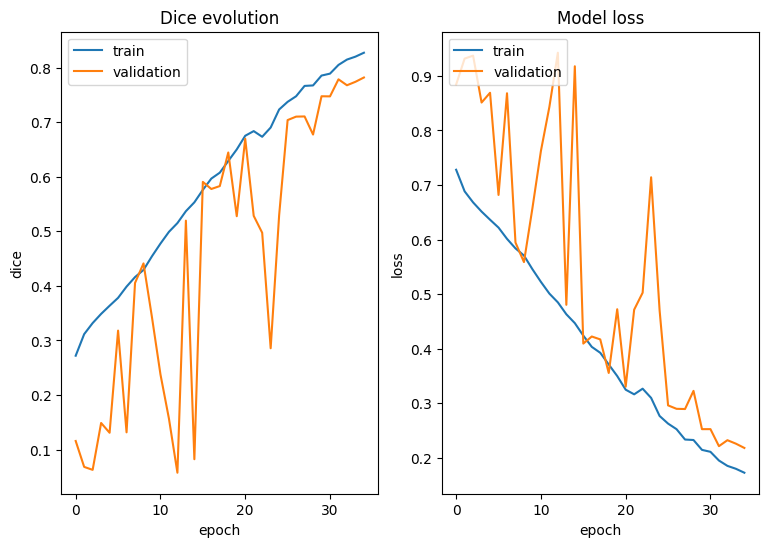

In [15]:
plt.figure(figsize=(9,6), dpi= 100, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.plot(training_history.history['dice'])
plt.plot(training_history.history['val_dice'])
plt.title('Dice evolution')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# "Loss"
plt.subplot(1,2,2)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

EXPERIMENT_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04'
plt.savefig(EXPERIMENT_PATH+f'/unet_ferides_rendiment.png')

**Molt important també**. Podem haver fet l'entrenament, però si en algun moment volem fer una altra prova naturalment tornar a entrenar la xarxa no és una opció, perquè perdem temps de computació en una feina que prèviament ja hem fet. Per això, podem guardar el model en un fitxer, i recuperar-lo posteriorment per a fer les prediccions que puguin fer falta. L'extensió del fitxer **sempre** ha de ser `.h5`.

In [16]:
unet.save(os.path.join(EXPERIMENT_PATH, "unet_ferides.h5"))

Si ara volem recuperar el model, ho farem de la següent manera. L'estat de la xarxa és idèndic a quan la vàrem guardar.

In [3]:
EXPERIMENT_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04'
from tensorflow.keras.models import load_model
loaded_model = load_model(os.path.join(EXPERIMENT_PATH, "unet_ferides.h5"), 
                          custom_objects={'dice_loss': dice_loss, 'dice': dice})

2024-07-06 02:19:47.588760: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-07-06 02:19:47.594999: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-06 02:19:47.595048: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: T-Series
2024-07-06 02:19:47.595060: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: T-Series
2024-07-06 02:19:47.595152: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.33.1
2024-07-06 02:19:47.595194: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.33.1
2024-07-06 02:19:47.595214: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.33.1
2024-07-06 02:19:47.595610: I tensorflow/core/platform/cpu_feature

## Prediccions amb la UNet

Fins ara hem implementat la UNet, l'hem entrenat i hem guardat els pesos a un fitxer per a poder fer futures prediccions. Això és el que pretenem fer en aquesta secció: passar-li una imatge a la UNet, i que ens faci la predicció. És important observar un fet: quan li passam imatges amb el generador, li estem donant amb una certa mida, i la xarxa ens torna les imatges també amb una certa mida de sortida. Però clar, no totes les imatges del dataset tenen la mateixa mida, ni tampoc tenen la mateixa mida $256\times 256$ que li imposam a la xarxa. Per aquest motiu, és important establir un criteri. Com que les màscares ens determinen la posició exacta de l'objecte, farem el següent:

1. Donada una imatge sobre la que volem fer la predicció, canviar la seva mida a la dimensió d'entrada de la xarxa.
2. Calcular la predicció del model, que ens tornarà una imatge en la dimensió de sortida del mateix. Aquesta sortida serà, **en el cas de la UNet**, una imatge amb entrades dins l'interval $[0,1]$, que podem interpretar com una imatge en escala de grisos.
3. Redimensionar aquesta sortida amb les dimensions de la imatge en qüestió.
4. Binaritzar el resultat de la passa anterior.
5. Comparar amb la màscara.

Un dubte que pot sorgir és si les passes 3 i 4 es poden permutar. La resposta és que no. Si primer binaritzam, quan facem el canvi d'escala posterior la imatge resultant **no** és, en general, binària. Hem de pensar que fer un canvi d'escala aplica per darrere una sèrie de tècniques d'interpolació, que poden donar lloc a imatges en escala de grisos, que no són comparables a la passa 4 amb la màscara final.

In [4]:
def predict_image(model: tf.keras.models.Model, model_input: Tuple[int, int], image: numpy.ndarray, binary_threshold: float=0.5):
    resized_image = skimage.transform.resize(image, (model_input[0], model_input[1], 3)) #Passa 1
    prediction_raw = model.predict(numpy.array([resized_image])) # Passa 2
    
    # Passa 3
    prediction = prediction_raw[0][:,:,0]
    prediction_resized = skimage.transform.resize(prediction, (image.shape[0], image.shape[1]))
    prediction_binary_bool = prediction_resized >= binary_threshold
    prediction_binary = 255*prediction_binary_bool
    
    return prediction_binary

In [19]:
test_image_name = "0SeVHyRODnGrnAURdi8tbneiS_infection=0_capture=1_resolution=0.png"
original_image = cv2.imread(os.path.join(REDSCAR_DATASET_TEST, "IMAGES", test_image_name))
gt_image = cv2.imread(os.path.join(REDSCAR_DATASET_TEST, "GT_WOUND_MASK", test_image_name), 0)

#result = predict_image(model=unet2, model_input=(256, 256), image=original_image)
# En lloc de unet2 també podem passar loaded_model. Són el mateix model i per tant fan la mateixa predicció.
result = predict_image(model=loaded_model, model_input=(256, 256), image=original_image)

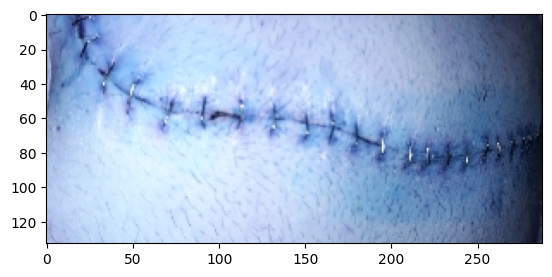

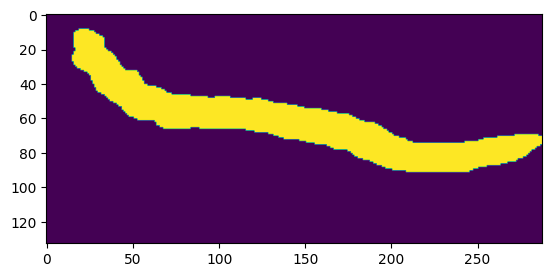

In [20]:
plt.imshow(original_image)
plt.show()

plt.imshow(result)
plt.show()

Ara implementarem dues funcions que reben per paràmetres la gt i la predicció i ens retornen la mètrica: la dice i la jaccard.

In [ ]:
# MARC: Les dues funcions que has implementat per al dice i al jaccard són correctes. Només un comentari: els dos bucles for
# els tens repetits. Millor implementar una funció que ens ho calculi, i retornar tp, fn, fp i tn (tot i que aquest no s'empri).

# Respecte els teus comentaris (en ordre d'aparició):
# - Sí, hem de comprovar que les condicions siguin iguals. No ho suposam.
# - Sí, hem de calcular les dimensions. Fixa't que a la funció predict_image hi ha un paràmetre que és model_input, que ens diu les 
#   dimensions del model. Aquí també ho hem de demanar. 

# Comentaris addicionals:
# - A les carpetes "IMAGES" i "GT_WOUND_MASK" tenen imatges amb el mateix nom. Per tant, ho fas bé. Si et vols curar en salut, 
#   una altra opció és llegir cada línia dels fitxers "UIB_EXPERIMENTS/REDSCAR/SUBSETS/MACHINE_LEARNING_DATASET/train.txt" i 
#   "UIB_EXPERIMENTS/REDSCAR/SUBSETS/MACHINE_LEARNING_DATASET/test.txt". Ja contenen els noms de les imatges. Els vàrem preparar
#   per aquest propòsit. No t'ho vaig dir al seu moment, però crec que pot ser més senzill. Igualment, si ho vols deixar així,
#   és correcte.
# - Quan guardes el fitxer csv no li indiques el nom. Hauria de ser RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/nom_fitxer.csv'.
#   Igualment, dins la carpeta Results hauries de posar Experiment01, i allà a dins posar-hi els resultats.
# - Una darrera observació. Has de fer les mètriques per train i test (només ho fas per train ara). També, has de guardar
#   totes les mètriques absolutes (TP, FN, FP i TN) per a cada imatge, tant de train com de test, ja que a partir d'elles
#   podem calcular-ne d'altres.

In [21]:
 def metriques_absolutes(gt_image, prediction):
    (n,m) = numpy.shape(gt_image)  
    
    if (n,m) != numpy.shape(prediction): # comprovació que les mides de la imatge de la predicció i la de la gt coincideixen
        return []
    
    [tp,fn,fp,tn] = [0,0,0,0] # si les mides coincideixen, calcularem les mètriques absolutes
    for i in range(n):
        for j in range(m):
            if gt_image[i][j]==255 and prediction[i][j]==255: 
                tp += 1
            elif gt_image[i][j]==255 and prediction[i][j]==0:
                fn += 1
            elif gt_image[i][j]==0 and prediction[i][j]==255:
                fp += 1
            elif gt_image[i][j]==0 and prediction[i][j]==0:
                tn += 1
                    
    return [tp,fn,fp,tn]

In [ ]:
# PROVA SI FUNCIONA LA CALCULADORA DE MÈTRIQUES ABSOLUTES
imatges_train = os.path.join(REDSCAR_DATASET_TRAIN, "IMAGES")
gt_train = os.path.join(REDSCAR_DATASET_TRAIN, "GT_WOUND_MASK")
    
nom_imatge = '3XOKKCioHUZbjDr5S21pGwHU6_infection=0_capture=1_resolution=1.png' #imatge amb 0s i 1s 

imatge = cv2.imread(os.path.join(imatges_train, nom_imatge), 1) # en color
gt = cv2.imread(os.path.join(gt_train, nom_imatge), 0) # escala de grisos

plt.imshow(imatge)
plt.show()

plt.imshow(gt)
plt.show()
#feim la predicció
#prediccio = predict_image(model=unet, model_input=(256, 256), image=imatge)
prediccio = predict_image(model=loaded_model, model_input=(256, 256), image=imatge)
plt.imshow(prediccio)
plt.show()

print(metriques_absolutes(gt, prediccio))

In [22]:
def dice_coefficient(gt_image, prediction):
    metriques = metriques_absolutes(gt_image, prediction)  
    
    if metriques == []:
        return []
    
    [tp,fn,fp,tn] = metriques
    # calculem el valor del coeficient de dice
    if (2*tp + fp + fn) == 0: #això voldria dir que tots el coefs. són TN i, per tant, ho fa bé
        dice = 1
    else:
        dice = 2*tp/(2*tp + fp + fn)
    
    return [tp,fn,fp,tn,dice]

In [23]:
def jaccard_coefficient(gt_image, prediction):
    metriques = metriques_absolutes(gt_image, prediction)
    
    if metriques == []:
        return []
    
    [tp,fn,fp,tn] = metriques
    # calculem el valor del coeficient de jaccard
    if (tp + fp + fn) == 0: #com abans, la predicció és bona
        jaccard = 1
    else:
        jaccard = tp/(tp + fp + fn)
    
    return [tp,fn,fp,tn,jaccard]

Ara avaluarem les imatges de train amb ambdues mètriques:

In [24]:
noms_imatges = []
dice_imatges = []
jaccard_imatges = []
tp_imatges = []
fn_imatges = []
fp_imatges = []
tn_imatges = []

imatges_train = os.path.join(REDSCAR_DATASET_TRAIN, "IMAGES")
gt_train = os.path.join(REDSCAR_DATASET_TRAIN, "GT_WOUND_MASK")

for nom_imatge in os.listdir(imatges_train): 
    
    noms_imatges.append(nom_imatge)
    imatge = cv2.imread(os.path.join(imatges_train,nom_imatge), 1) # en color
    gt = cv2.imread(os.path.join(gt_train,nom_imatge), 0) # escala de grisos
    #feim la predicció
    prediccio = predict_image(model=loaded_model, model_input=(256, 256), image=imatge)
    
    #avaluam amb cada mètrica
    dice_resultat = dice_coefficient(gt, prediccio)
    if dice_resultat != []:
        dice = dice_resultat[-1]
        dice_imatges.append(dice)
        jaccard = jaccard_coefficient(gt, prediccio)[-1]
        jaccard_imatges.append(jaccard)
        tp = dice_resultat[0]
        tp_imatges.append(tp)
        fn = dice_resultat[1]
        fn_imatges.append(fn)
        fp = dice_resultat[2]
        fp_imatges.append(fp)
        tn = dice_resultat[3]
        tn_imatges.append(tn)
        
    else:
        dice_imatges.append(None)
        jaccard_imatges.append(None)
        tp_imatges.append(None)
        fp_imatges.append(None)
        fn_imatges.append(None)
        tn_imatges.append(None)
    
import pandas as pd

# cream un DataFrame
unet_ferides_train = pd.DataFrame({'NOM IMATGE': noms_imatges, 'DICE': dice_imatges, 'JACCARD': jaccard_imatges, 'TP': tp_imatges, 'FN': fn_imatges, 'FP': fp_imatges, 'TN': tn_imatges})

# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04/unet_ferides_train.csv'
unet_ferides_train.to_csv(RESULTATS_PATH, index=False)


Farem el mateix amb les imatges de test:

In [25]:
noms_imatges = []
dice_imatges = []
jaccard_imatges = []
tp_imatges = []
fn_imatges = []
fp_imatges = []
tn_imatges = []

imatges_test = os.path.join(REDSCAR_DATASET_TEST, "IMAGES")
gt_test = os.path.join(REDSCAR_DATASET_TEST, "GT_WOUND_MASK")

for nom_imatge in os.listdir(imatges_test): 
    
    noms_imatges.append(nom_imatge)
    imatge = cv2.imread(os.path.join(imatges_test,nom_imatge), 1) # en color
    gt = cv2.imread(os.path.join(gt_test,nom_imatge), 0) # escala de grisos
    #feim la predicció
    prediccio = predict_image(model=loaded_model, model_input=(256, 256), image=imatge)
    
    #avaluam amb cada mètrica
    dice_resultat = dice_coefficient(gt, prediccio)
    if dice_resultat != []:
        dice = dice_resultat[-1]
        dice_imatges.append(dice)
        jaccard = jaccard_coefficient(gt, prediccio)[-1]
        jaccard_imatges.append(jaccard)
        tp = dice_resultat[0]
        tp_imatges.append(tp)
        fn = dice_resultat[1]
        fn_imatges.append(fn)
        fp = dice_resultat[2]
        fp_imatges.append(fp)
        tn = dice_resultat[3]
        tn_imatges.append(tn)
        
    else:
        dice_imatges.append(None)
        jaccard_imatges.append(None)
        tp_imatges.append(None)
        fp_imatges.append(None)
        fn_imatges.append(None)
        tn_imatges.append(None)
    
import pandas as pd

# cream un DataFrame
unet_ferides_test = pd.DataFrame({'NOM IMATGE': noms_imatges, 'DICE': dice_imatges, 'JACCARD': jaccard_imatges, 'TP': tp_imatges, 'FN': fn_imatges, 'FP': fp_imatges, 'TN': tn_imatges})

# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04/unet_ferides_test.csv'
unet_ferides_test.to_csv(RESULTATS_PATH, index=False)


## Algunes prediccions:
Per a poder veure com de bé ho fa la xarxa UNet, guardarem algunes prediccions. 

Ara implementarem diverses funcions per a obtenir visualitzacions dels resultats

In [13]:
# funció ppal que cridarà a les altres:
def visualitzacions(model, noms_imatges: list, ruta_imatges: str, ruta_gt: str, input_size: int, ruta_guardar: str, titol: str, qualitat: int):
    k = 1 
    for nom in noms_imatges:
        # carregam la imatge, la gt i feim la predicció
        imatge = cv2.imread(os.path.join(ruta_imatges, nom), 1) # en color
        gt = cv2.imread(os.path.join(ruta_gt, nom), 0) # escala de grisos
        prediccio = predict_image(model=loaded_model, model_input=(input_size, input_size), image=imatge)
        
        # cridam a la funció que dibuixa la prediccio sobre la imatge original
        res1 = mascara(imatge,prediccio)
        cv2.imwrite(ruta_guardar+rf"/{titol}_{k}_mascara.png", res1)
        
        # cridam a la funció que dibuixa els contorns de la predicció i de la gt sobre la imatge original
        res2 = contorns(imatge, prediccio, gt, qualitat)
        cv2.imwrite(ruta_guardar+rf"/{titol}_{k}_contorns.png", res2)
        plt.imshow(res2)
        plt.show()
        
        k += 1

In [14]:
# funció auxiliar que dibuixa la predicció sobre la imatge original:
def mascara(imatge, prediccio):
    mascara = imatge.copy()
    for i in range(imatge.shape[0]):
        for j in range(imatge.shape[1]):
            if prediccio[i, j] > 0:  
                mascara[i, j] = [107,183,189]  # Paint in yellow
    return mascara    

In [5]:
# funció auxiliar que dibuixa els contorns de la gt i de la prediccio sobre la imatge original:
# color gt = green; color prediccio = red
def contorns(imatge, prediccio, gt, qualitat):
    resultat = imatge.copy()
    # PREDICCIO
    # find contours with hierarchy
    contours, hier = cv2.findContours(prediccio.astype(numpy.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
                                                # how the contours are retrieved and organized, contour approximation method
    # Define sufficient enough colors for blobs (taques)
    colors = [(0, 255, 0), (0, 0, 255)] # green and red (BGR format)
    k = -1
    for i, cnt in enumerate(contours):
        if (hier[0, i, 3] == -1):  # Check if the current contour has no parent, i.e., the contour is an external contour
            k += 1
        if qualitat == 1:
            cv2.drawContours(resultat, [cnt], -1, colors[1], 5) #pintam la predicció de vermell
        else:
            cv2.drawContours(resultat, [cnt], -1, colors[1], 1) #pintam la predicció de vermell

        
    # GT
    # find contours with hierarchy
    contours, hier = cv2.findContours(gt.astype(numpy.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                                                # how the contours are retrieved and organized, contour approximation method
    k = -1
    for i, cnt in enumerate(contours):
        if (hier[0, i, 3] == -1):  # Check if the current contour has no parent, i.e., the contour is an external contour
            k += 1
        if qualitat == 1:
            cv2.drawContours(resultat, [cnt], -1, colors[0], 5) #pintam la gt de verd
        else:
            cv2.drawContours(resultat, [cnt], -1, colors[0], 1) #pintam la gt de verd
    return resultat

## Filtratge 1: millors i pitjors imatges d'alta resolució

In [16]:
# carregam el data frame de test:
import pandas as pd
df = pd.read_csv('/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04/unet_ferides_test.csv')

# filtram les imatges d'alta resolució -> df1:
df1 = df[df['NOM IMATGE'].str.endswith('resolution=1.png')]

# l'ordenam en funció del coeficient dice
df1_sorted = df1.sort_values(by='DICE',ascending=False).reset_index(drop=True)# ordenem el df de major a menor coef. de dice
                                                       # per a accedir més fàcilment a les imatges que volem seleccionar

print(df1_sorted)

                                           NOM IMATGE      DICE   JACCARD  \
0   mYK7RLzwiniuS242ozwJGMnVp_infection=0_capture=...  0.942260  0.890823   
1   TBNtKYTcLfWmsAq7HPMBqhoIP_infection=0_capture=...  0.923183  0.857327   
2   Rnod1BInWHCTgdRWAltq1LejC_infection=0_capture=...  0.920027  0.851899   
3   xKeO8oUXQ67e6htu8HDk5Dau0_infection=0_capture=...  0.916814  0.846406   
4   yggFQdnroH00JH5jRMieJsQgD_infection=0_capture=...  0.909684  0.834330   
..                                                ...       ...       ...   
65  THvsyRd09uwgs7n4hUoytNGsa_infection=0_capture=...  0.542749  0.372448   
66  Hm7gwnrmEuFw7ZhMyAfC6ouIM_infection=0_capture=...  0.533955  0.364215   
67  P8RhAHQY5StAbedV1qrwOXFu0_infection=0_capture=...  0.515471  0.347229   
68  AAb0Z0BZMuyDQL1tQLRrCnAwb_infection=1_capture=...  0.291423  0.170565   
69  YzLNpYW33lmFgkqNRUKgIzj1J_infection=0_capture=...  0.000000  0.000000   

         TP      FN      FP        TN  
0   1010892   72937   50955  147904

In [17]:
nom_tots = []
dice_tots = []

# seleccionam les 10 millors
nom_millors = []
for i in range(10):
    nom = df1_sorted.loc[i,"NOM IMATGE"]
    nom_millors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(df1_sorted.loc[i,"DICE"])
    
# seleccionam les 5 pitjors
nom_pitjors = []
n = df1_sorted.shape[0]
# iteram a les 5 darreres files
for i in range(n-5,n):
    nom = df1_sorted.loc[i,"NOM IMATGE"]
    dice_value = df1_sorted.loc[i,"DICE"]
    nom_pitjors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(dice_value)
print(nom_millors)
print(nom_tots) 
print(dice_tots)
resultats_unet_alta = pd.DataFrame({'NOM':nom_tots, 'DICE':dice_tots})
# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04/unet_ferides_resultats_alta.csv'
resultats_unet_alta.to_csv(RESULTATS_PATH, index=False)

['mYK7RLzwiniuS242ozwJGMnVp_infection=0_capture=1_resolution=1.png', 'TBNtKYTcLfWmsAq7HPMBqhoIP_infection=0_capture=0_resolution=1.png', 'Rnod1BInWHCTgdRWAltq1LejC_infection=0_capture=0_resolution=1.png', 'xKeO8oUXQ67e6htu8HDk5Dau0_infection=0_capture=1_resolution=1.png', 'yggFQdnroH00JH5jRMieJsQgD_infection=0_capture=1_resolution=1.png', 'KnclSSvSGyJt26zuAelrcgQ6b_infection=0_capture=1_resolution=1.png', 'WANam2apfdanNh00ghp4TsVq4_infection=0_capture=0_resolution=1.png', '1Nt2Dcn2ztA8EIzggVYdBkhTb_infection=0_capture=1_resolution=1.png', 'cmXdDDV3WNmd4ghvPpgDFBEBq_infection=0_capture=1_resolution=1.png', 'OmW5Rka7xqI5ASYPGUzcXQU8m_infection=0_capture=1_resolution=1.png']
['mYK7RLzwiniuS242ozwJGMnVp_infection=0_capture=1_resolution=1.png', 'TBNtKYTcLfWmsAq7HPMBqhoIP_infection=0_capture=0_resolution=1.png', 'Rnod1BInWHCTgdRWAltq1LejC_infection=0_capture=0_resolution=1.png', 'xKeO8oUXQ67e6htu8HDk5Dau0_infection=0_capture=1_resolution=1.png', 'yggFQdnroH00JH5jRMieJsQgD_infection=0_capture

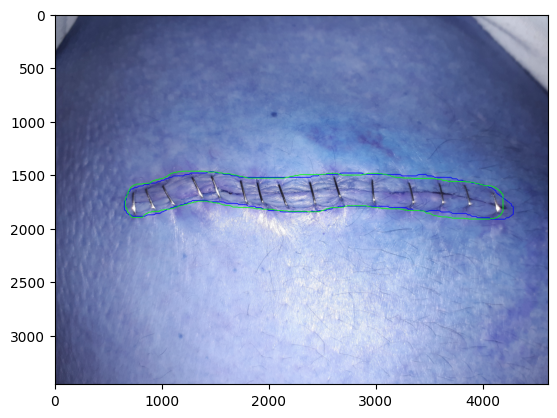

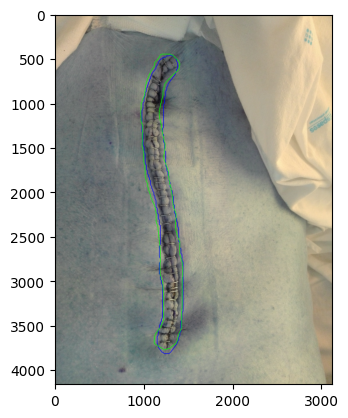

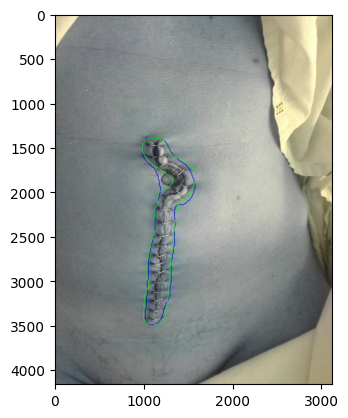

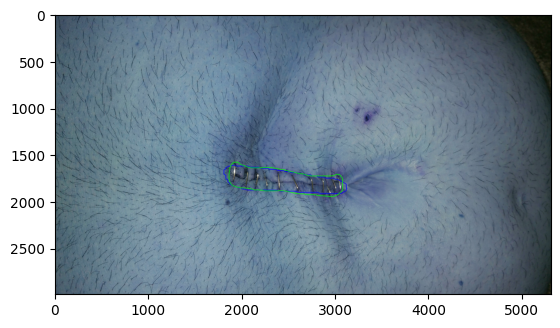

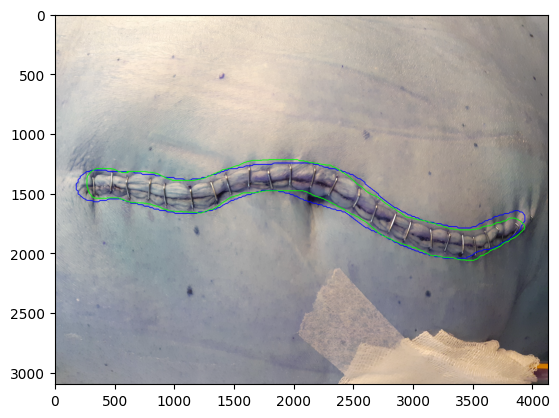

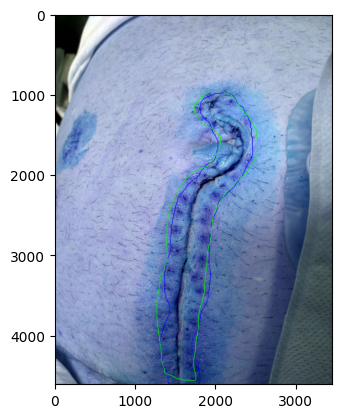

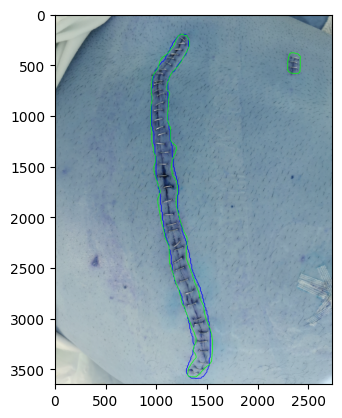

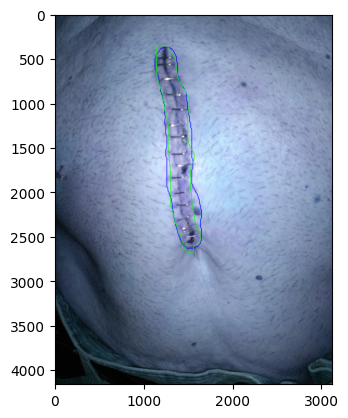

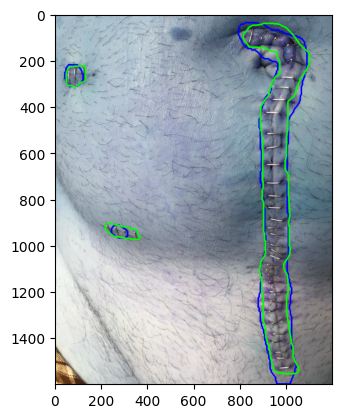

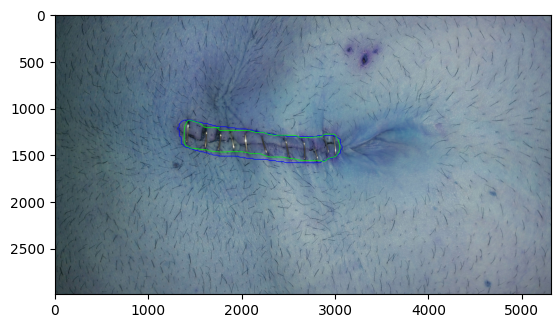

In [18]:
ruta_millors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04/alta_resolucio_10_millors'

ruta_imatge = os.path.join(REDSCAR_DATASET_TEST,'IMAGES')
ruta_gts = os.path.join(REDSCAR_DATASET_TEST,'GT_WOUND_MASK')

# guardam les millors
visualitzacions(model=loaded_model, noms_imatges=nom_millors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_millors, titol="millor", qualitat=1)


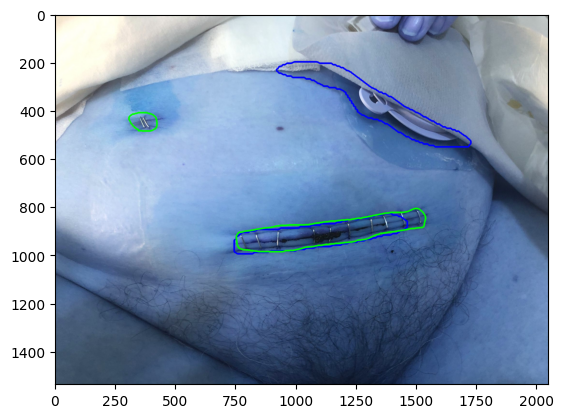

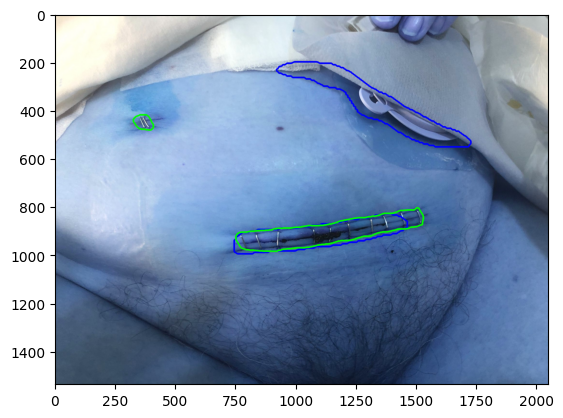

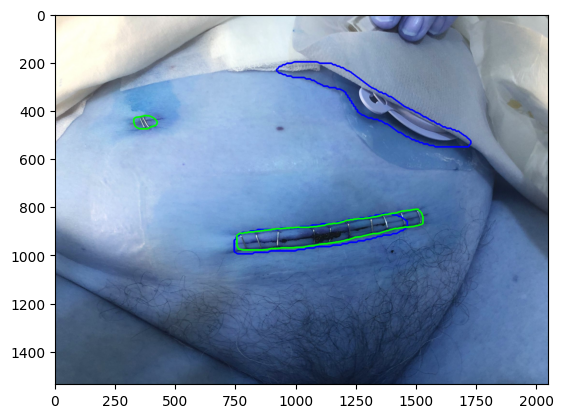

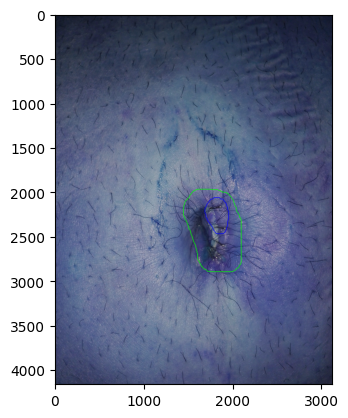

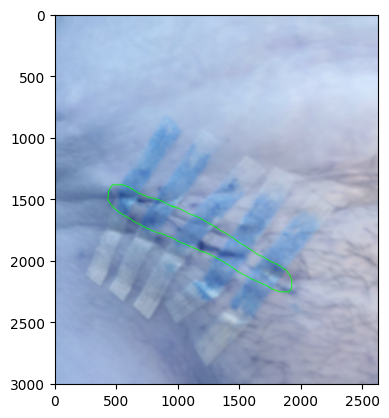

In [19]:
ruta_pitjors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04/alta_resolucio_5_pitjors'

# guardam les pitjors
visualitzacions(model=loaded_model, noms_imatges=nom_pitjors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_pitjors, titol="pitjor", qualitat=1)


## Filtratge 2: millors i pitjors imatges de baixa resolució

In [20]:
# filtram les imatges d'alta resolució -> df2:
df2 = df[df['NOM IMATGE'].str.endswith('resolution=0.png')]

# l'ordenam en funció del coeficient dice
df2_sorted = df2.sort_values(by='DICE',ascending=False).reset_index(drop=True)# ordenem el df de major a menor coef. de dice
                                                       # per a accedir més fàcilment a les imatges que volem seleccionar

print(df2_sorted)

                                           NOM IMATGE      DICE   JACCARD  \
0   fsQjP7gdPYnqNWbJACkayeaK8_infection=0_capture=...  0.939733  0.886318   
1   7PsK2pKVrkofRQKGB6yIyAmqv_infection=0_capture=...  0.924789  0.860100   
2   tSBNbbT8NVk7wj1KEn5UVHOtU_infection=0_capture=...  0.924300  0.859255   
3   zU1LXaMl34s64fxf22resmwfs_infection=0_capture=...  0.923911  0.858582   
4   89Cmrsk0up7FIc0NwQcL5vvwS_infection=0_capture=...  0.915195  0.843649   
5   oedJksR9vFzg5fybwB07HlNyY_infection=0_capture=...  0.912305  0.838751   
6   Q8Gc67NrWWZCNTJ39HMHWPvoj_infection=0_capture=...  0.908279  0.831970   
7   XIIlLL72NJGmdAye6jDJ5O9af_infection=0_capture=...  0.903302  0.823657   
8   uVwV3ym6HlHt68akS9ipapFz2_infection=0_capture=...  0.894716  0.809490   
9   SqzMLLMyU4icHeeVFWe5FAuGb_infection=0_capture=...  0.889510  0.801008   
10  Fx0AqjASOabanLluuy4HFC5xj_infection=0_capture=...  0.888337  0.799107   
11  JTl8COuBKzbJmsiUsT62fW4qp_infection=0_capture=...  0.881472  0.788065   

In [21]:
nom_tots = []
dice_tots = []

# seleccionam les 10 millors
nom_millors = []
for i in range(10):
    nom = df2_sorted.loc[i,"NOM IMATGE"]
    nom_millors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(df2_sorted.loc[i,"DICE"])
    
# seleccionam les 5 pitjors
nom_pitjors = []
n = df2_sorted.shape[0]
# iteram a les 5 darreres files
for i in range(n-5,n):
    nom = df2_sorted.loc[i,"NOM IMATGE"]
    dice_value = df2_sorted.loc[i,"DICE"]
    nom_pitjors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(dice_value)
print(nom_millors)
print(nom_tots) 
print(dice_tots)
resultats_unet_baixa = pd.DataFrame({'NOM':nom_tots, 'DICE':dice_tots})
# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04/unet_ferides_resultats_baixa.csv'
resultats_unet_baixa.to_csv(RESULTATS_PATH, index=False)

['fsQjP7gdPYnqNWbJACkayeaK8_infection=0_capture=1_resolution=0.png', '7PsK2pKVrkofRQKGB6yIyAmqv_infection=0_capture=1_resolution=0.png', 'tSBNbbT8NVk7wj1KEn5UVHOtU_infection=0_capture=1_resolution=0.png', 'zU1LXaMl34s64fxf22resmwfs_infection=0_capture=1_resolution=0.png', '89Cmrsk0up7FIc0NwQcL5vvwS_infection=0_capture=1_resolution=0.png', 'oedJksR9vFzg5fybwB07HlNyY_infection=0_capture=1_resolution=0.png', 'Q8Gc67NrWWZCNTJ39HMHWPvoj_infection=0_capture=1_resolution=0.png', 'XIIlLL72NJGmdAye6jDJ5O9af_infection=0_capture=1_resolution=0.png', 'uVwV3ym6HlHt68akS9ipapFz2_infection=0_capture=1_resolution=0.png', 'SqzMLLMyU4icHeeVFWe5FAuGb_infection=0_capture=1_resolution=0.png']
['fsQjP7gdPYnqNWbJACkayeaK8_infection=0_capture=1_resolution=0.png', '7PsK2pKVrkofRQKGB6yIyAmqv_infection=0_capture=1_resolution=0.png', 'tSBNbbT8NVk7wj1KEn5UVHOtU_infection=0_capture=1_resolution=0.png', 'zU1LXaMl34s64fxf22resmwfs_infection=0_capture=1_resolution=0.png', '89Cmrsk0up7FIc0NwQcL5vvwS_infection=0_capture

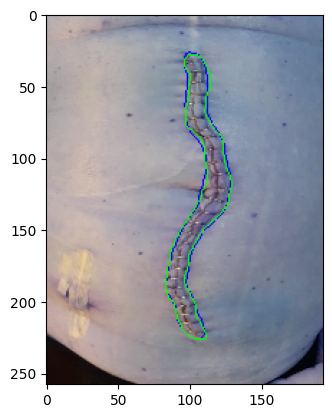

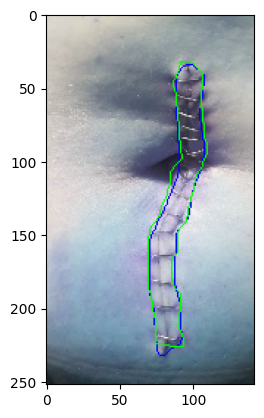

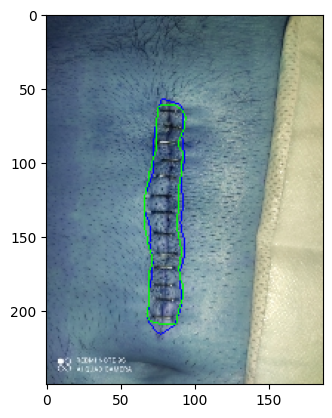

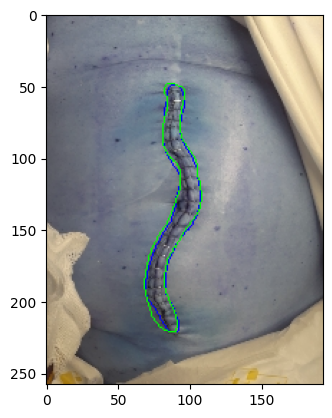

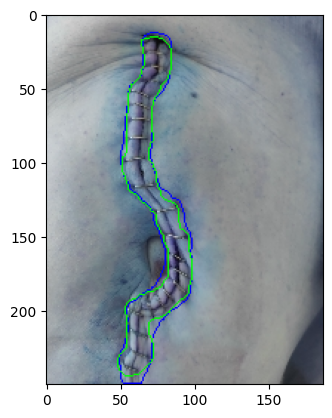

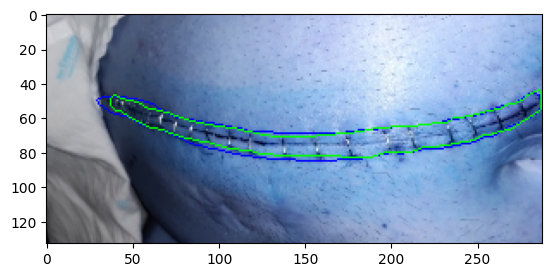

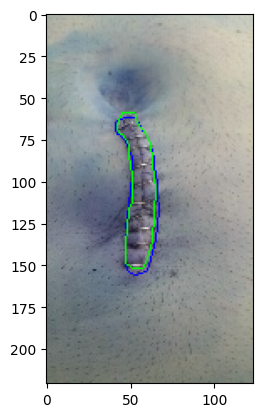

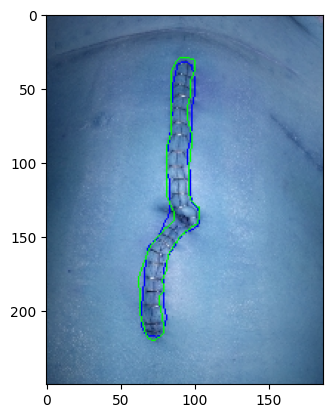

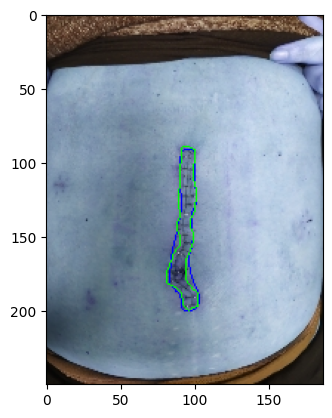

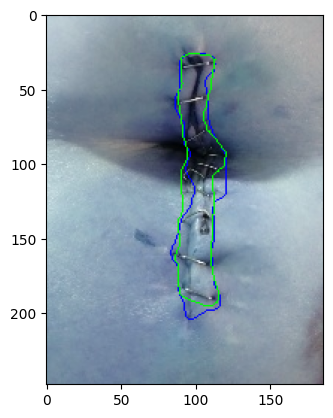

In [22]:
ruta_millors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04/baixa_resolucio_10_millors'

# guardam les millors
visualitzacions(model=loaded_model, noms_imatges=nom_millors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_millors, titol="millor", qualitat=0)

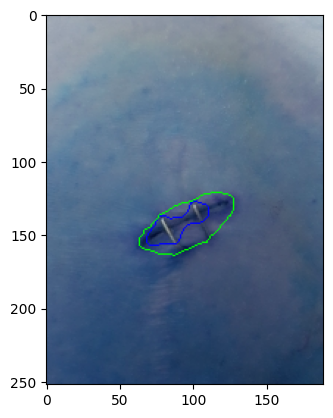

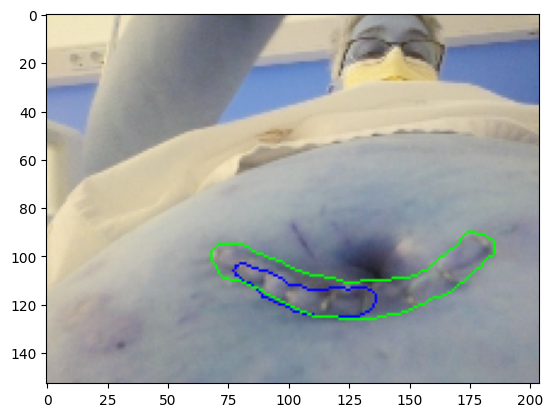

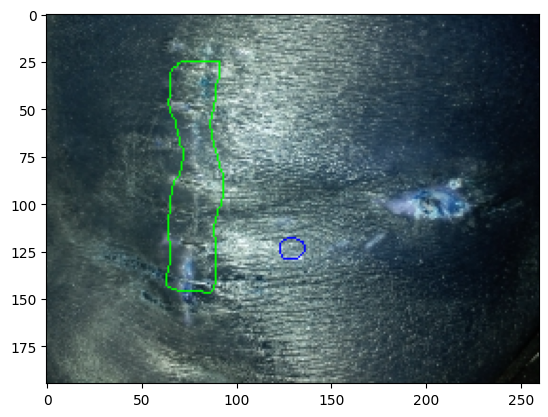

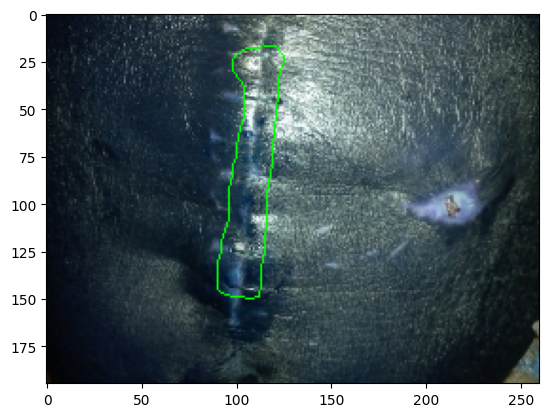

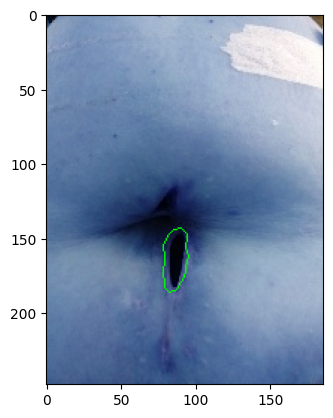

In [23]:
ruta_pitjors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04/baixa_resolucio_5_pitjors'

# guardam les pitjors
visualitzacions(model=loaded_model, noms_imatges=nom_pitjors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_pitjors, titol="pitjor", qualitat=0)

In [6]:
REDSCAR_DATASET = "/home/marc/UIB_EXPERIMENTS/REDSCAR"
REDSCAR_DATASET_TEST = os.path.join(REDSCAR_DATASET, "SUBSETS", "MACHINE_LEARNING_DATASET", "test")
ruta_imatges = os.path.join(REDSCAR_DATASET_TEST,'IMAGES')
ruta_gt_f = os.path.join(REDSCAR_DATASET_TEST,'GT_WOUND_MASK')
ruta_gt_g = os.path.join(REDSCAR_DATASET_TEST,'GT_STAPLES_MASK')
rutes_gt = [ruta_gt_f, ruta_gt_g]

nom = '2FrdqfR9OA980pwauusQZJ3Th_infection=0_capture=0_resolution=1.png'
original = cv2.imread(os.path.join(ruta_imatges, nom), 1)
gt_f = cv2.imread(os.path.join(rutes_gt[0], nom), 0) # escala de grisos
gt_g = cv2.imread(os.path.join(rutes_gt[1], nom), 0) # escala de grisos
prediccio_f = predict_image(model=loaded_model, model_input=(256, 256), image=original)

ruta_guardar = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment04/alta_resolucio_10_millors'

imatge_f = contorns(original, prediccio_f, gt_f, 1)
cv2.imwrite(ruta_guardar+rf"/unet_f.png", imatge_f)


True